In [1]:
import pandas as pd
import requests
import os
from datetime import datetime
from data_creation import download_ecallisto_files, LOCAL_DATA_FOLDER
from glob import glob
from radiospectra.sources import CallistoSpectrogram
from spectogram_utils import spec_to_pd_dataframe, plot_spectogram, masked_spectogram_to_array
from database_utils import extract_instrument_name, glob_files, extract_constant_meta_data, extract_separate_instruments, create_dict_of_instrument_paths

In [2]:
from database_functions import *
from database_utils import *
import numpy as np
from tqdm import tqdm

In [3]:
test = glob_files(LOCAL_DATA_FOLDER, datetime(2023, 1, 25).date(), datetime(2023, 2, 8).date(), file_name_pattern="*AUSTRIA-UNIGRAZ_20230203_143000_02*")

In [4]:
spec = CallistoSpectrogram.read(test[0])

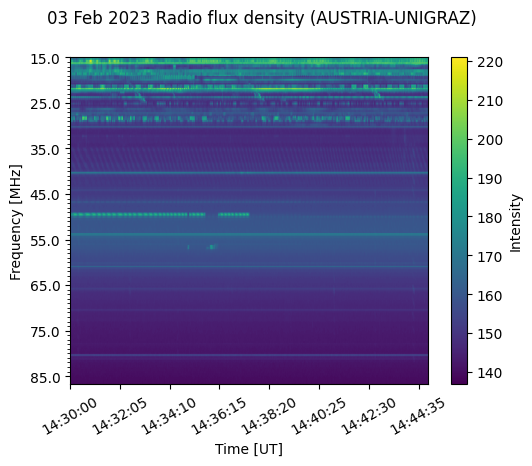

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [5]:
spec.peek()

In [7]:
get_table_names_sql()

['malaysia_banting_01',
 'india_ooty_02',
 'ssrt_59',
 'roswell_nm_57',
 'poland_grotniki_03',
 'egypt_alexandria_01',
 'usa_arizona_erau_01',
 'spain_siguenza_02',
 'mexico_lance_a_63',
 'germany_dlr_62',
 'mexico_lance_b_62',
 'egypt_alexandria_02',
 'australia_lmro_59',
 'india_gauri_59',
 'australia_assa_60',
 'romania_01',
 'almaty_58',
 'swiss_hb9sct_01',
 'bir_01',
 'alaska_haarp_62',
 'glasgow_01',
 'mrt1_02',
 'alaska_cohoe_63',
 'alaska_cohoe_62',
 'arecibo_observatory_62',
 'australia_assa_63',
 'norway_ny_aalesund_01',
 'germany_dlr_63',
 'humain_59',
 'germany_dlr_01',
 'india_ooty_01',
 'spain_peralejos_03',
 'mongolia_ub_01',
 'austria_oe3flb_55',
 'triest_60',
 'swiss_irsol_01',
 'spain_peralejos_62',
 'mro_62',
 'alaska_haarp_63',
 'roswell_nm_59',
 'triest_59',
 'spain_peralejos_63',
 'algeria_craag_59',
 'japan_ibaraki_59',
 'swiss_muhen_62',
 'mrt3_03',
 'norway_egersund_01',
 'roswell_nm_58',
 'mro_59',
 'austria_oe3flb_57',
 'alaska_anchorage_01',
 'hurbanovo_59',

In [10]:
swiss = [x for x in get_table_names_sql() if "swiss" in x.lower()]

In [11]:
swiss

['swiss_hb9sct_01',
 'swiss_irsol_01',
 'swiss_muhen_62',
 'swiss_landschlacht_63',
 'swiss_landschlacht_62',
 'swiss_muhen_63',
 'swiss_muhen_03']

In [12]:
data = timebucket_values_from_database_sql('swiss_landschlacht_63', '2023-01-25 02:30:00', '2023-02-08 03:30:00', timebucket='5m', agg_function='AVG')

SELECT time_bucket('5m', datetime) AS time, AVG("45.0") AS "45.0",AVG("45.5") AS "45.5",AVG("46.375") AS "46.375",AVG("46.5629997253418") AS "46.5629997253418",AVG("47.375") AS "47.375",AVG("47.6879997253418") AS "47.6879997253418",AVG("48.375") AS "48.375",AVG("48.5629997253418") AS "48.5629997253418",AVG("49.25") AS "49.25",AVG("49.5629997253418") AS "49.5629997253418",AVG("50.4379997253418") AS "50.4379997253418",AVG("50.6879997253418") AS "50.6879997253418",AVG("51.3129997253418") AS "51.3129997253418",AVG("51.6879997253418") AS "51.6879997253418",AVG("52.3129997253418") AS "52.3129997253418",AVG("52.6879997253418") AS "52.6879997253418",AVG("53.375") AS "53.375",AVG("53.5629997253418") AS "53.5629997253418",AVG("54.375") AS "54.375",AVG("54.625") AS "54.625",AVG("55.4379997253418") AS "55.4379997253418",AVG("55.8129997253418") AS "55.8129997253418",AVG("56.4379997253418") AS "56.4379997253418",AVG("56.5") AS "56.5",AVG("57.375") AS "57.375",AVG("57.75") AS "57.75",AVG("58.43799972

In [107]:
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,345
0,2023-02-02 13:25:00,138.2888086642599278,138.0722021660649819,138.1119133574007220,137.9314079422382671,138.1841155234657040,137.8953068592057762,137.9422382671480144,138.1985559566787004,138.0000000000000000,...,None,None,None,None,None,None,None,None,None,None
1,2023-02-02 13:30:00,137.9600000000000000,137.6191666666666667,137.8150000000000000,137.6350000000000000,137.8391666666666667,137.5083333333333333,137.6816666666666667,137.8766666666666667,137.6975000000000000,...,None,None,None,None,None,None,None,None,None,None
2,2023-02-02 13:35:00,137.6675000000000000,137.3491666666666667,137.5541666666666667,137.3191666666666667,137.5616666666666667,137.2333333333333333,137.3600000000000000,137.5516666666666667,137.3783333333333333,...,None,None,None,None,None,None,None,None,None,None
3,2023-02-02 13:40:00,137.5478767693588676,137.2131557035803497,137.3888426311407161,137.2073272273105745,137.4371357202331391,137.0957535387177352,137.2239800166527893,137.4462947543713572,137.2239800166527893,...,None,None,None,None,None,None,None,None,None,None
4,2023-02-02 13:45:00,138.3466666666666667,137.9333333333333333,138.1675000000000000,138.1475000000000000,138.5008333333333333,137.8891666666666667,138.0341666666666667,138.2691666666666667,138.1016666666666667,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,2023-02-07 15:50:00,None,144.1883333333333333,None,None,None,141.5808333333333333,None,None,None,...,140.5708333333333333,140.4791666666666667,140.2883333333333333,140.0733333333333333,139.8775000000000000,139.6100000000000000,139.4975000000000000,139.3433333333333333,139.1708333333333333,139.0541666666666667
615,2023-02-07 15:55:00,None,144.2466666666666667,None,None,None,141.6633333333333333,None,None,None,...,140.5366666666666667,140.4900000000000000,140.2841666666666667,140.0400000000000000,139.8208333333333333,139.6175000000000000,139.4766666666666667,139.2816666666666667,139.1650000000000000,139.0491666666666667
616,2023-02-07 16:00:00,None,144.2916666666666667,None,None,None,141.6750000000000000,None,None,None,...,140.5916666666666667,140.4891666666666667,140.3116666666666667,140.0691666666666667,139.8641666666666667,139.6341666666666667,139.5075000000000000,139.3525000000000000,139.2033333333333333,139.0358333333333333
617,2023-02-07 16:05:00,None,144.3575000000000000,None,None,None,141.7708333333333333,None,None,None,...,140.6550000000000000,140.5491666666666667,140.3458333333333333,140.1508333333333333,139.9125000000000000,139.6808333333333333,139.5316666666666667,139.3950000000000000,139.2483333333333333,139.1266666666666667


In [16]:
data = get_values_from_database_sql('india_ooty_02', '2023-01-25 02:30:00', '2023-02-08 03:30:00')
columns = get_column_names_sql('india_ooty_02')
columns = [to_float_if_possible(column) for column in columns]

In [17]:
data_new = pd.DataFrame(data, index=pd.to_datetime([row[0] for row in data]))
data_new.resample('5m').mean()

/tmp/ipykernel_563913/2275562262.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_new.resample('5m').mean()


,1,2,3,4,5,6,7,8,9,10,...,184,185,186,187,188,189,190,191,192,193
2023-01-31,140.463751,142.798579,147.209237,160.708469,149.394360,141.976341,140.592492,139.923495,139.157055,137.867114,...,168.814170,171.000684,172.877047,174.93525,177.123780,178.860035,176.926463,171.665739,173.042619,159.854289
2023-06-30,140.172053,142.500788,147.008683,160.463613,148.767525,142.276801,140.859351,140.162330,139.447530,138.185881,...,168.987805,171.347425,173.172272,175.11995,176.849558,177.462099,174.478586,170.377398,171.736953,159.416028


In [ ]:
for instrument in get_table_names_sql():
    data = get_values_from_database_sql(instrument, '2023-02-01 02:30:00', '2023-02-02 03:30:00')
    columns = get_column_names_from_table_sql(instrument)
    columns = [to_float_if_possible(column) for column in columns]

In [ ]:
d

In [ ]:
df_spec = sql_result_to_df(data, columns, meta_data={'instrument': 'india_ooty_02'})
df_spec.head()

,164.938004,164.313004,163.688004,163.063004,162.438004,161.813004,161.188004,160.563004,159.938004,159.313004,...,50.563000,49.938000,49.313000,48.688000,48.063000,47.438000,46.813000,46.188000,45.563000,45.000000
datetime,,,,,,,,,,,,,,,,,,,,,
2023-02-01 02:30:00.563,141,146,157,200,156,140,140,141,139,138,...,168,171,173,174,177,181,178,172,173,161
2023-02-01 02:30:00.813,141,147,157,199,157,141,140,139,139,138,...,169,170,173,174,178,180,179,173,174,161
2023-02-01 02:30:01.063,142,146,157,199,156,140,140,140,139,138,...,169,171,172,175,177,180,178,173,174,161
2023-02-01 02:30:01.313,142,146,157,200,157,140,140,141,140,138,...,168,171,172,175,177,180,178,172,172,161
2023-02-01 02:30:01.563,142,146,157,199,156,140,141,140,139,137,...,169,169,172,174,176,179,178,172,173,161


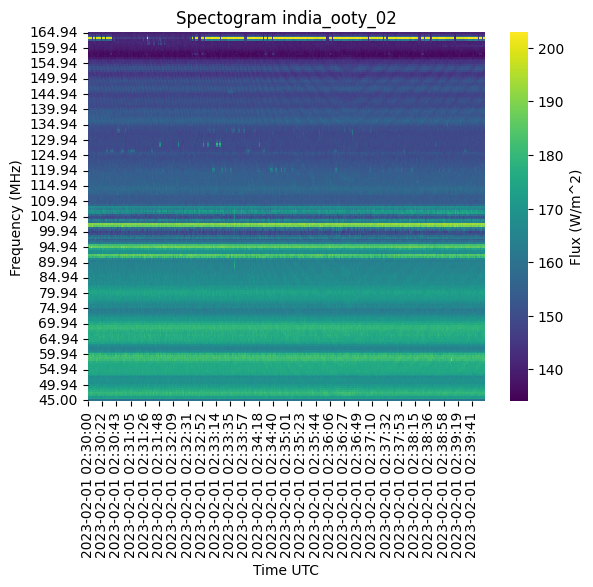

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_spectogram(spectogram, sunflare_type=None):
    spectogram = spectogram.copy()
    spectogram.index = spectogram.index.strftime("%Y-%m-%d %H:%M:%S")
    spectogram.columns = [f"{col:.2f}" for col in spectogram.columns]
    ax = sns.heatmap(spectogram.T, cmap="viridis", cbar_kws={"label": "Flux (W/m^2)"})
    title = f'Spectogram {spectogram.attrs["instrument"]}'
    if sunflare_type is not None:
        title += f". Sunflaretype: {sunflare_type}"
    plt.title(title)
    plt.ylabel("Frequency (MHz)")
    plt.xlabel("Time UTC")
    plt.show()
plot_spectogram(df_spec)

In [ ]:
df_spec.index.strftime("%Y-%m-%d %H:%M:%S").is_monotonic_increasing 

False

In [ ]:
df_spec.index.strftime("%Y-%m-%d %H:%M:%S")

Index(['2023-02-01 02:30:00', '2023-02-01 02:30:00', '2023-02-01 02:30:01',
       '2023-02-01 02:30:01', '2023-02-01 02:30:01', '2023-02-01 02:30:01',
       '2023-02-01 02:30:02', '2023-02-01 02:30:02', '2023-02-01 02:30:02',
       '2023-02-01 02:30:02',
       ...
       '2023-02-01 02:39:57', '2023-02-01 02:39:58', '2023-02-01 02:39:58',
       '2023-02-01 02:39:58', '2023-02-01 02:39:58', '2023-02-01 02:39:59',
       '2023-02-01 02:39:59', '2023-02-01 02:39:59', '2023-02-01 02:39:59',
       '2023-02-01 02:30:00'],
      dtype='object', name='datetime', length=2399)